# Import modules and read data

In [1]:
import numpy as np
import pandas as pd
from pipedream_solver.superlink import SuperLink
from pipedream_solver.simulation import Simulation

In [2]:
# Specify data path
input_path = '../data/orifice_test'

# Get model components
superjunctions = pd.read_csv(f'{input_path}/superjunctions.csv')
superlinks = pd.read_csv(f'{input_path}/superlinks.csv')
junctions = pd.read_csv(f'{input_path}/junctions.csv')
links = pd.read_csv(f'{input_path}/links.csv')
orifices = pd.read_csv(f'{input_path}/orifices.csv')

# Read input data
Q_in = pd.read_csv(f'{input_path}/flow_input.csv', index_col=0)
H_bc = pd.read_csv(f'{input_path}/boundary_stage.csv', index_col=0)

In [3]:
superlinks['in_offset'] = 0
superlinks['out_offset'] = 0

# Create and run hydraulic model

In [4]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, orifices=orifices)    

In [5]:
# Set initial timestep
dt = 30
# Set orifice opening time
orifice_start_time = 15000

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in, H_bc=H_bc) as simulation:
    # While simulation time has not expired...
    for step in simulation.steps:
        if simulation.t >= simulation.t_end:
            break
        # If orifice open time is reached...
        if simulation.t >= orifice_start_time:
            # Turn orifice on
            u = np.ones(1)
        else:
            # Turn orifice off
            u = np.zeros(1)
        # Step model forward in time
        simulation.step(dt=dt, u_o=u, subdivisions=2, retries=5)
        # Adjust step size
        dt = simulation.compute_step_size(dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()

[==================================================] 100.0% [19.69 s]

# Plot results

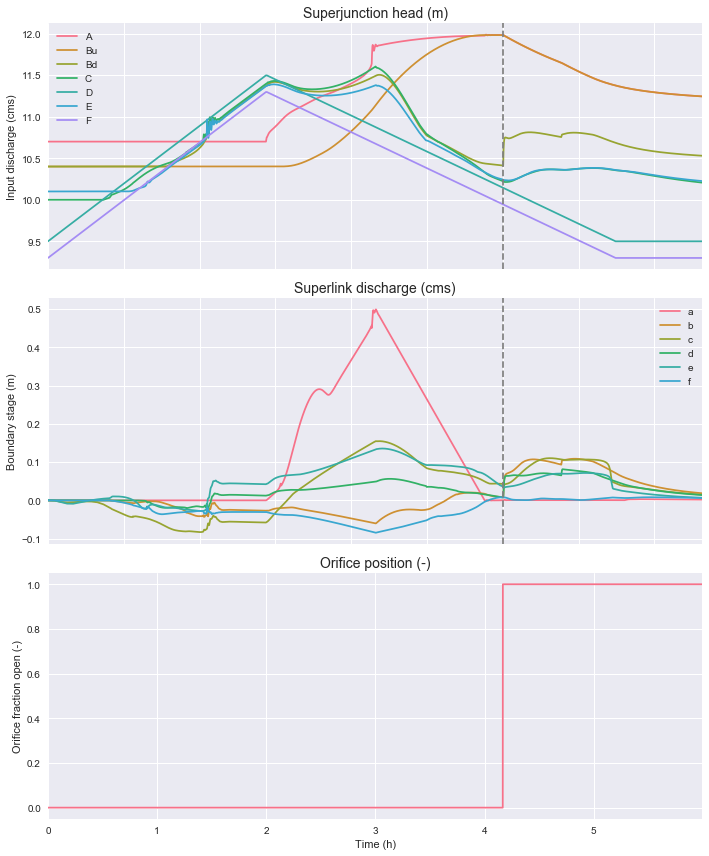

In [7]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl', 8)
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(3, figsize=(10, 12))

# Compute average discharge in superlinks
simulation.states.Q_k = (simulation.states.Q_uk + simulation.states.Q_dk) / 2

# Create vector to show control signal
u = np.zeros(int(simulation.t))
u[15000:] = 1.

# Plot results
simulation.states.H_j.plot(ax=ax[0], title='Superjunction head (m)')
simulation.states.Q_k.plot(ax=ax[1], title='Superlink discharge (cms)')
ax[2].plot(np.arange(len(u)) / 3600, u)
ax[2].set_title('Orifice position (-)')

ax[0].axvline(orifice_start_time, linestyle='--', c='0.5')
ax[1].axvline(orifice_start_time, linestyle='--', c='0.5')

# Configure plots
ax[0].set_ylabel('Input discharge (cms)')
ax[1].set_ylabel('Boundary stage (m)')
ax[2].set_ylabel('Orifice fraction open (-)')
ax[2].set_xlim(np.asarray(ax[0].get_xlim()) / 3600)
ax[0].title.set_size(14)
ax[1].title.set_size(14)
ax[2].title.set_size(14)
ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
ax[2].set_xlabel('Time (h)')
plt.tight_layout()